In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, CategoricalAccuracy
from sklearn.model_selection import train_test_split
from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support.metadata_writers import writer_utils
from sklearn.model_selection import train_test_split
from tflite_support import metadata as _metadata
from tflite_support import metadata_writers
from tflite_support import metadata
from google.colab.files import upload
from PIL import Image
import flatbuffers
import io


In [2]:
!wget https://storage.googleapis.com/sweple.appspot.com/models/dataset.zip

--2024-06-20 16:19:28--  https://storage.googleapis.com/sweple.appspot.com/models/dataset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81059523 (77M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  77.30M  35.4MB/s    in 2.2s    

2024-06-20 16:19:31 (35.4 MB/s) - ‘dataset.zip’ saved [81059523/81059523]



In [3]:
import zipfile

current_dir = os.getcwd()
local_zip = './dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
# Split dataset into training and testing sets

dataset_dir = "/content/dataset"
split = "/content/split"

train_dir = os.path.join(split, 'train')
test_dir = os.path.join(split, 'test')


os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


for i in os.listdir(dataset_dir):
    sub_dir = os.listdir(os.path.join(dataset_dir, i))

    curr_dir = os.path.join(dataset_dir, i)

    os.makedirs(os.path.join(train_dir, i), exist_ok=True)
    os.makedirs(os.path.join(test_dir, i), exist_ok=True)

    train_images, test_images = train_test_split(sub_dir, test_size=0.2, random_state=42)

    for image in train_images:
        shutil.move(os.path.join(curr_dir, image), os.path.join(train_dir, i, image))
    for image in test_images:
        shutil.move(os.path.join(curr_dir, image), os.path.join(test_dir, i, image))
    shutil.rmtree(curr_dir)

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

Found 722 images belonging to 64 classes.
Found 201 images belonging to 64 classes.


In [6]:
classes_train = train_generator.class_indices
classes_test = test_generator.class_indices
print("Training samples:", train_generator.samples)
print("Testing samples:", test_generator.samples)

Training samples: 722
Testing samples: 201


In [7]:
print("Class Indicate", train_generator.class_indices)

Class Indicate {'Astor Chocolate 40g': 0, 'Astor Matcha 40g': 1, 'Bear Brand Susu Steril 189ml': 2, 'Beng-Beng Share It 95g': 3, 'Buavita Apel 245ml': 4, 'Buavita Jambu 245ml': 5, 'Buavita Jeruk 245ml': 6, 'Buavita Korean White Peach 245ml': 7, 'Buavita Leci 245ml': 8, 'Buavita Mangga 245ml': 9, 'Chimi Jagung Bakar 50g': 10, 'Chitato Lite Rumput Laut 68g': 11, 'Cimory Fresh Milk Almond 250ml': 12, 'Cimory Fresh Milk Blueberry 250ml': 13, 'Cimory Fresh Milk Cashew 250ml': 14, 'Cimory Fresh Milk Choco Malt 250ml': 15, 'Cimory Fresh Milk Strawberry 250ml': 16, 'Cimory Yogurt Drink Blueberry 240ml': 17, 'Cimory Yogurt Drink Low Fat Strawberry & Mango 240ml': 18, 'Cimory Yogurt Drink Lychee 240ml': 19, 'Cimory Yogurt Drink Strawberry 240ml': 20, 'Coca Cola Original 390ml': 21, 'Coca Cola Zero Sugar 390ml': 22, 'Fanta Rasa Jeruk 390ml': 23, 'Fanta Rasa Stroberi 390ml': 24, 'French Fries 2000 62g': 25, 'Garuda Kacang Atom Original 17g': 26, 'Hello Panda Chocolate Cream 42g': 27, 'Hello Panda 

In [11]:
# Create a MirroredStrategy to use both GPUs
mirrored_strategy = tf.distribute.MirroredStrategy()

# Compile the model under the MirroredStrategy
with mirrored_strategy.scope():
    # Load pre-trained InceptionV3 model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(229, 229, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(len(classes_train), activation='softmax')(x)

    # Create the new model
    model = tf.keras.Model(inputs=base_model.input, outputs=x)

    model.compile(optimizer=Adam(),
                  loss=CategoricalCrossentropy(from_logits=True),
                  metrics=[CategoricalAccuracy()])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=8, min_delta=0.001)

    history = model.fit(train_generator,
          epochs=100,
          batch_size=32,
          validation_data=test_generator,
          callbacks=[early_stopping],
          verbose=1)


Epoch 1/100
23/23 [==============================] - 23s 685ms/step - loss: 4.1164 - categorical_accuracy: 0.0859 - val_loss: 3.4353 - val_categorical_accuracy: 0.1940
Epoch 2/100
23/23 [==============================] - 14s 595ms/step - loss: 3.0205 - categorical_accuracy: 0.2604 - val_loss: 2.7475 - val_categorical_accuracy: 0.3085
Epoch 3/100
23/23 [==============================] - 13s 582ms/step - loss: 2.3492 - categorical_accuracy: 0.4169 - val_loss: 2.2816 - val_categorical_accuracy: 0.4428
Epoch 4/100
23/23 [==============================] - 13s 577ms/step - loss: 2.0198 - categorical_accuracy: 0.4875 - val_loss: 1.9049 - val_categorical_accuracy: 0.5622
Epoch 5/100
23/23 [==============================] - 14s 599ms/step - loss: 1.8170 - categorical_accuracy: 0.5042 - val_loss: 1.6196 - val_categorical_accuracy: 0.6119
Epoch 6/100
23/23 [==============================] - 13s 588ms/step - loss: 1.5508 - categorical_accuracy: 0.5831 - val_loss: 1.4469 - val_categorical_accuracy:

In [ ]:
# history = model.fit(train_generator,
#           epochs=20,
#           validation_data=test_generator,
#           verbose=1)

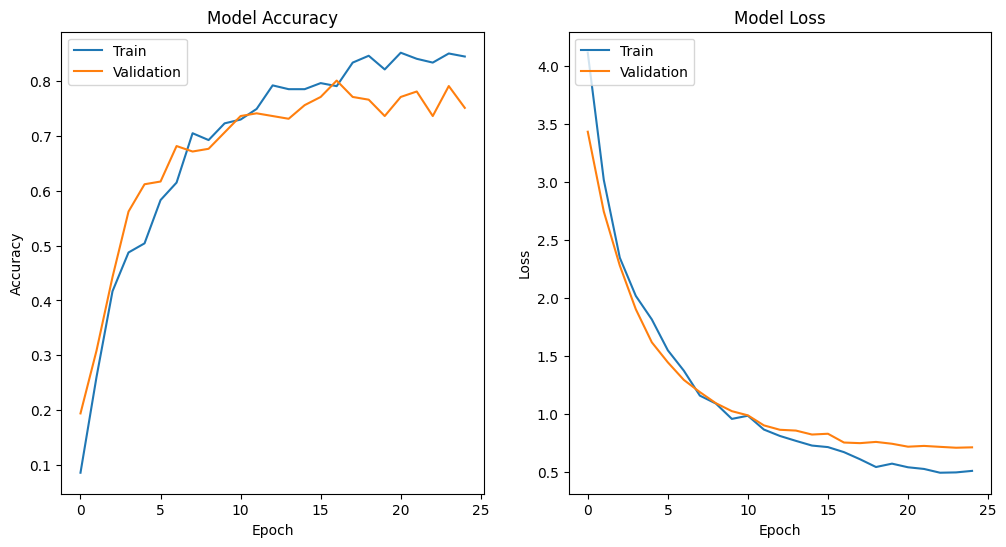

In [12]:
# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Saving Teh Pucuk Harum 500ml (1).jpg to Teh Pucuk Harum 500ml (1).jpg
Saving Ultra Sari Kacang Ijo 250ml (10).jpg to Ultra Sari Kacang Ijo 250ml (10).jpg
Saving Oatside Barista Blend 200ml (13).jpg to Oatside Barista Blend 200ml (13).jpg
User uploaded file "Teh Pucuk Harum 500ml (1).jpg" with length 65671 bytes
1/1 [==============================] - 0s 73ms/step


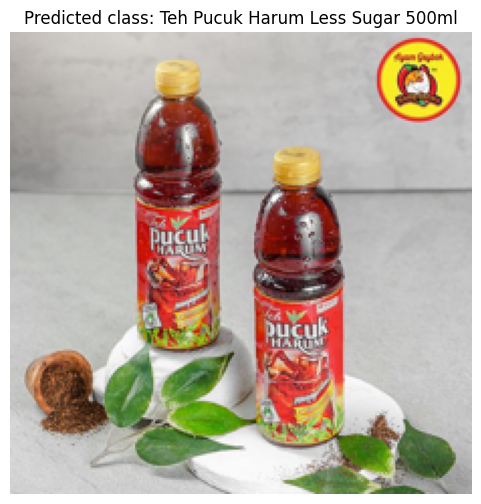

User uploaded file "Ultra Sari Kacang Ijo 250ml (10).jpg" with length 44560 bytes
1/1 [==============================] - 0s 72ms/step


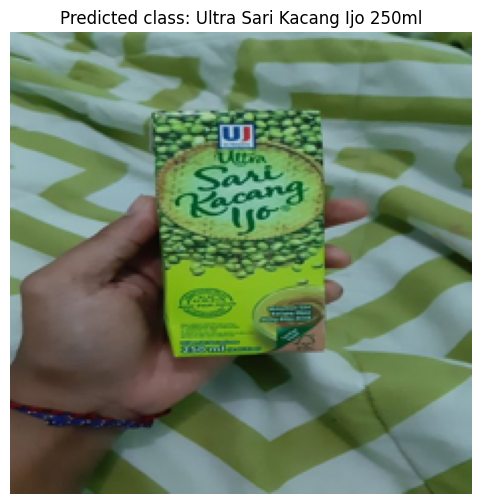

User uploaded file "Oatside Barista Blend 200ml (13).jpg" with length 24723 bytes
1/1 [==============================] - 0s 74ms/step


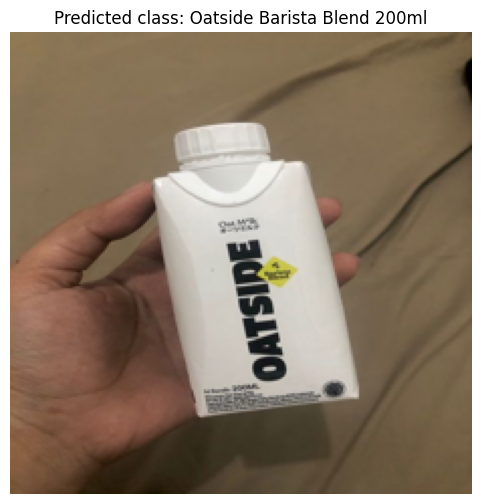

In [16]:
# Test the model on a new image
import io
from PIL import Image
from google.colab.files import upload
uploaded = upload()

for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=filename, length=len(uploaded[filename])))

    # Load the uploaded image
    image = Image.open(io.BytesIO(uploaded[filename]))

    # Preprocess the image
    image = image.resize((229, 229))
    image_array = np.array(image) / 255.0
    image_tensor = np.expand_dims(image_array, axis=0)

    # Make predictions
    predictions = model.predict(image_tensor)
    predicted_class = np.argmax(predictions[0])

    # Display the image with the predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted class: {list(classes_train.keys())[list(classes_train.values()).index(predicted_class)]}")
    plt.axis('off')
    plt.show()

In [17]:
#save your model in the SavedModel format
export_dir = 'inceptionv3/saved_model'
tf.saved_model.save(model, export_dir)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the model.
with open('inception_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [18]:

!pip install tensorflow==2.13.0 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.6/882.6 kB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
!pip install tflite-support


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 28.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.13.0 which is incompatible.


In [7]:

sorted_class_indices = sorted(train_generator.class_indices.items(), key=lambda x: x[1])
sorted_class_names = [class_name for class_name, index in sorted_class_indices]

labels_path = "/content/labels.txt"

with open(labels_path, 'w') as f:
    for class_name in sorted_class_names:
        f.write(class_name + '\n')

print(f"Labels saved to {labels_path}")

Labels saved to /content/labels.txt


In [8]:
# Paths for the model and label file
_MODEL_PATH = "/content/inception_model.tflite"
_LABEL_FILE = "/content/labels.txt"
_SAVE_TO_PATH = "/content/inception_metadata.tflite"

# Normalization parameters for the input image
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create model metadata
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "Gizilo image classifier"
model_meta.description = (
    "Identify branded retail products and make grading for these products "
    "based on the calculation of nutritional value."
)
model_meta.version = "v1"
model_meta.author = "Core Gizilo"
model_meta.license = (
    "Apache License. Version 2.0 "
    "http://www.apache.org/licenses/LICENSE-2.0."
)

# Create input metadata
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is 229 x 229, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255."
)
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = _metadata_fb.ColorSpaceType.RGB
input_meta.content.contentPropertiesType = _metadata_fb.ContentProperties.ImageProperties

input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = _metadata_fb.ProcessUnitOptions.NormalizationOptions
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [_INPUT_NORM_MEAN]
input_normalization.options.std = [_INPUT_NORM_STD]
input_meta.processUnits = [input_normalization]

input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

# Create output metadata
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = _metadata_fb.ContentProperties.FeatureProperties

output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats

label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename(_LABEL_FILE)
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

# Create subgraph metadata
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

# Build the flatbuffer
b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER
)
metadata_buf = b.Output()

# Populate metadata into the model
populator = _metadata.MetadataPopulator.with_model_file(_MODEL_PATH)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files([_LABEL_FILE])
populator.populate()

# Save the model with metadata
writer_utils.save_file(writer_utils.load_file(_MODEL_PATH), _SAVE_TO_PATH)

# Optionally display metadata
displayer = _metadata.MetadataDisplayer.with_model_file(_SAVE_TO_PATH)
export_json_file = "model_metadata.json"
json_file = displayer.get_metadata_json()

with open(export_json_file, "w") as f:
    f.write(json_file)

print(f"Metadata populated and saved to {_SAVE_TO_PATH}")
print(f"Metadata JSON saved to {export_json_file}")


Metadata populated and saved to /content/inception_metadata.tflite
Metadata JSON saved to model_metadata.json


In [10]:
displayer = metadata.MetadataDisplayer.with_model_file("/content/inception_metadata.tflite")
print("Metadata populated:")
print(displayer.get_metadata_json())

print("Associated file(s) populated:")
for file_name in displayer.get_packed_associated_file_list():
  print("file name: ", file_name)
  print("file content:")
  print(displayer.get_associated_file_buffer(file_name))
with open("model_metadata.json", "w") as f:
  f.write(displayer.get_metadata_json())

Metadata populated:
{
  "name": "Gizilo image classifier",
  "description": "Identify branded retail products and make grading for these products based on the calculation of nutritional value.",
  "version": "v1",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified. The expected image is 229 x 229, with three channels (red, blue, and green) per pixel. Each value in the tensor is a single byte between 0 and 255.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          

In [16]:
# Get user input for the image path
image_path = input("Enter the path to the image you want to predict: ")

# Load the image
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(229, 229))

# Preprocess the image
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image /= 255.0

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/inception_metadata.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run the model
interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()

# Get the prediction
predictions = interpreter.get_tensor(output_details[0]['index'])

# Print the prediction
predicted_class = np.argmax(predictions)
print(f"Predicted class: {list(classes_train.keys())[list(classes_train.values()).index(predicted_class)]}")

Enter the path to the image you want to predict: /content/Teh Pucuk Harum 500ml (1).jpg
Predicted class: Teh Pucuk Harum Less Sugar 500ml
